<h1 style='color:orange; font-weight:bold; text-align:center'>Optimizing Ride Fares: A Dynamic Pricing Model for Ride-Sharing Services</h1>

## **1 Introduction**
### **1.1 Context**
Dynamic pricing is a strategy where price is adjusted in real-time based on various factors, including market demand. For instance, during peak holiday seasons, the price for a daily pass may increase to balance the demand. This approach aims to optimize revenue and manage demand more effectively.

A bike-sharing company currently aims to implement dynamic pricing where the fare of the daily pass adapts to different factors so that the company can generate higher profit during high demands and still maintain profitability during low demands. 

### **1.2 Problem Statement**
Currently, ride fares are only determined by using ride duration which does not account for fluctuating demand or supply imbalances. This static approach can lead to inefficiencies and reduced profitability. The bik-ride sharing company is exploring dynamic pricing strategies to adapt the fares of their daily pass to improve profitability.

### **1.3 Objective**
My objective is to develop a dynamic pricing model adjusting fares based on real-time factors to maximize the company's revenue. This will involve building and evaluatiing a regression model to predict optimal fare adjustments.

### **1.4 Metrics**
As the model is designed to optimize fares based on real-time conditions, a misprediction of the model can be either under or overestimation, particularly if excessive, of the fares, resulting in business impacts in relation to revenue, satisfaction, and reputation. On one hand, underestimation occurs when the model predicts fares lower than it should be, causing increased demand and missing out on potential revenue. On the other hand, overestimation can deter potential customers, and hence, leading to lower ride volume and reduced revenue. 
To simulate the financial impacts of the misprediction by the model, let us see the following hypothetical scenario using Divvy's data for an illustration purpose.
- **Underestimation of cost**: If the model underestimates the fare by USD0.50 on average, and there are 533K per month (average of 2022 ride data, [Chicago Tribune, 2024](https://www.chicagotribune.com/2023/06/30/divvy-bikes-hit-the-streets-of-chicago-10-years-ago-the-decade-has-been-filled-with-changes-and-challenges/#:~:text=Total%20Divvy%20rides%20each%20month%20from%202013%20to%202023&Trends%20show%20that%20ridership%20peaks,growth%20over%20the%20last%20decade.&And%20much%20of%20that%20growth,see%20ridership%20totals%20each%20year.)), the monthly revenue loss will be approximately USD266.5K.
- **Overestimation of cost**: If the regression model overprices customers, there will be reduction in bike-sharing demand since the high service cost can deter potential customers. If the model makes errors by 5% per month, there will be 26.65K customers who gets overpricing. When we multiply this number of customers with Divvy's daily pass at USD 18.10 ([Divvy, 2024](https://divvybikes.com/pricing)), it means the bike-ride sharing company will lose approximately USD 482.3K per month.

Based on these two conditions, the relevant metrics to evaluate machine learning model's predictions are R-squared ($R^2$), Mean Absolute Error, and Root Mean Squared Error.
- **Coefficient of determination** ($R^2$): It represents the proportion of variance in the target variable explained by the features. This ML metric provides a general overview of the model fit, helping us understand the explanatory power of the model.
$$R^2=1-\frac{\sum_i(y_i-\hat{y}_i)^2}{\sum_i(y_i-\bar{y})^2}$$
- **Mean Absolute Error** (MAE): It measures the average absolute difference between predicted ($\hat{y}_i$) and actual values ($y_i$), enabling us to evaluate the average magnitude of errors made by the model. The lower score of MAE indicates that the model is a better fit to the data.
$$\text{MAE} = \frac{1}{n}\sum_{i=1}^n|y_i - \hat{y}_i|$$
- **Root Mean Squared Error** (RMSE): It measures the average squared difference between predicted ($\hat{y}_i$) and actual prices ($y_i$). In its interpretation, the lower RMSE score of a model, the better the model fits to the data.
$$\text{RMSE}=\sqrt{\frac{1}{n}\sum_{i=1}^1(y_i-\hat{y_1})^2}$$

### **1.5 Dataset**
The dataset was obtained from [Möbius](https://www.kaggle.com/datasets/arashnic/dynamic-pricing-dataset/data) on Kaggle. In general, the dataset contains 10 variables (listed below). And one variable, namely `Historical_Cost_of_Ride` will become the target variable for the dynamic pricing model.
- `Number_of_Riders`: Number of customers who use the bike-sharing service (int)
- `Number_of_Drivers`: Available supply of drivers
- `Location_Category`: Geographical area where the ride is requested.
- `Customer_Loyalty_Status`: Membership type, e.g., silver or gold
- `Average_Ratings`: Average satisfaction score given by the customer
- `Time_of_Booking`: Time of the day when the ride is booked
- `Vehicle_Type`: Type of vehicle requested
- `Expected_Ride_Duration`: Estimated duration of the ride
- `Historical_Cost_of_Ride`: Previous cost

In [267]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, kstest, shapiro 
plt.style.use('ggplot')
import ptitprince as pt
import phik
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
import time
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
pd.options.display.max_colwidth = 80

## **2 Data Understanding**
In this section, my aim is to find out the overview of the data in terms of sanity. Each answer of the questions will provide an understanding what treatment I should give to the data to avoid introducing errors in the machine learning model's predictions. Not only model's predictions become biased or not trustworthy, but inferential statistical tests can also give an invalid conclusions.
- how many numerical and categorical variables
- how many duplicates are
- whether there are any missing values
- whether the distributions of the numerical variables are normal
- whether the dataset suffers from high cardinality and rarity
- whether there are any measurement errors, and 
- whether there are any incorrect data types.

### **2.1 General data overview**
To begin with, I will build a function to inspect a dataframe. This function is useful when later checking a dataframe is done repetitively. Furthermore, with respect to some insights I need to find out above, I will need the function to inform me the number of variables based on their data types, the number of observations (rows), the number of missing values, the number of duplicates, and some examples of the variable.

In [212]:
# create function to inspect df
def inspect_dataframe(df):
    print(f'The dataframe contains {df.shape[0]} rows and {df.shape[1]} cols.')
    print(f"- {len(df.select_dtypes(include='number').columns)} are numeric cols")
    print(f"- {len(df.select_dtypes(include='O').columns)} are object cols")
    summary = {
        'ColumnName': df.columns.values.tolist(),
        'Nrow': df.shape[0],
        'DataType': df.dtypes.values.tolist(),
        'NAPct': (df.isna().mean() * 100).round(2).tolist(),
        'DuplicatePct': (df.duplicated().sum()/len(df)*100).round(2),
        'UniqueValue': df.nunique().tolist(),
        'Sample': [df[col].unique() for col in df.columns]
    }
    return pd.DataFrame(summary)

In [268]:
# load dataset
df = pd.read_csv('../data/dynamic_pricing.csv')

# remove underscore in colnames
df.columns = df.columns.str.replace('_', '')

# inspect dataframe
inspect_dataframe(df)

The dataframe contains 1000 rows and 10 cols.
- 6 are numeric cols
- 4 are object cols


,ColumnName,Nrow,DataType,NAPct,DuplicatePct,UniqueValue,Sample
0,NumberofRiders,1000,int64,0.0,0.0,81,"[90, 58, 42, 89, 78, 59, 93, 62, 79, 86, 60, 24, 36, 63, 39, 38, 46, 33, 31,..."
1,NumberofDrivers,1000,int64,0.0,0.0,79,"[45, 39, 31, 28, 22, 35, 43, 14, 6, 17, 38, 8, 24, 13, 12, 7, 11, 16, 19, 33..."
2,LocationCategory,1000,object,0.0,0.0,3,"[Urban, Suburban, Rural]"
3,CustomerLoyaltyStatus,1000,object,0.0,0.0,3,"[Silver, Regular, Gold]"
4,NumberofPastRides,1000,int64,0.0,0.0,101,"[13, 72, 0, 67, 74, 83, 44, 71, 21, 99, 15, 50, 88, 30, 35, 49, 24, 6, 79, 1..."
5,AverageRatings,1000,float64,0.0,0.0,151,"[4.47, 4.06, 3.99, 4.31, 3.77, 3.51, 4.41, 3.59, 3.74, 3.85, 4.69, 4.14, 4.1..."
6,TimeofBooking,1000,object,0.0,0.0,4,"[Night, Evening, Afternoon, Morning]"
7,VehicleType,1000,object,0.0,0.0,2,"[Premium, Economy]"
8,ExpectedRideDuration,1000,int64,0.0,0.0,171,"[90, 43, 76, 134, 149, 128, 16, 47, 167, 144, 164, 83, 102, 140, 54, 15, 22,..."
9,HistoricalCostofRide,1000,float64,0.0,0.0,1000,"[284.25727302188227, 173.87475274940766, 329.7954689622466, 470.201231751319..."


**Note**
- The dataset contains 10 features, consisting of 6 numerical features (`NumberofRiders`, `NumberofDrivers`, `NumberofPastRides`, `ExpectedRideDuration`, and `HistoricalCostofRide`) and 4 categorical ones (`LocationCategory`, `CustomerLoyaltyStatus`, `TimeofBooking`, and `VehicleType`). For the numerical features, as some have large values, rescaling will be required to prevent one or more features predominating others during the machine learning training. The effect of this predomination is that the features can greatly affect the model's prediction since the model will prioritize the large values. And for the categorical ones, I will transform them into numerical values so that they can be processed by the model. However, which type of scaling and encoding should be done remains an open question here since I do not have enough information yet about the numerical and the categorical features.
- The data size is relatively small (*N* = 1,000). Decision on what amount of data should be the training set will later become crucial.
- In addition to data types, the dataset is clean enough. It does not contain any missing values, duplicates, and high cardinality. While there are no cardinality shown here, a further check must be carried out to see if there are any rare values in the categorical features. The rare values can introduce potential bias to the machine learning model. For example, the model will prioritize the frequent values over the rare ones during the predictions.

### **2.2 Data distribution**
Checking data distribution is not only critical for statistical tests, especially the inferential ones, but also for machine learning. In machine learning, non-normally distributed data affects feature scaling. For instance, if the data for a specific feature does not follow Gaussian distribution (bell-shaped curve), using standard scaler or min-max scaler will not be optimal because they are greatly affected by extreme values. Moreover, some models such as linear regressions or Gaussian Naive Bayes assume normality of distribution. While the models may still make predictions on the skewed distribution, their predictions may be less accurate.

Testing whether the numerical features follow normal distributions or not, I will firstly need some descriptive statistics such as min, max, and quantiles (Q1, Q2, and Q3). These metrics can give me a sense of spread of data numerically.

In [214]:
# check distribution of data numerically
df.select_dtypes(include='number').describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
NumberofRiders,1000.0,60.37,23.70,20.00,40.00,60.00,81.00,100.00
NumberofDrivers,1000.0,27.08,19.07,5.00,11.00,22.00,38.00,89.00
NumberofPastRides,1000.0,50.03,29.31,0.00,25.00,51.00,75.00,100.00
AverageRatings,1000.0,4.26,0.44,3.50,3.87,4.27,4.63,5.00
ExpectedRideDuration,1000.0,99.59,49.17,10.00,59.75,102.00,143.00,180.00
HistoricalCostofRide,1000.0,372.50,187.16,25.99,221.37,362.02,510.50,836.12


**Note**
- At glance, `HistoricalCostofDrive` appears to have outliers since the values at the 3rd quantile is far from the max value at 836.12.
- However, this result is not a guarantee that this feature do contains outliers and outliers in other numerical features are absent. To make sure, I will perform another test on outliers using interquartile range (IQR).
- But because this section is concerned with data distribution, I will focus more on testing the distributions numerically and visually. Both tests are needed because they can complement each other. While the numerical test can quantify the distribution characteristics, the visual test can quickly reveal shape of the distribution and the presence of outliers. Combining these tests, therefore, can provide a more comprehensive understanding for a decision making about the next step.

In [215]:
# check data distribution
df_numeric = (df.select_dtypes(include='number'))
ks_pvalues = df_numeric.apply(lambda col: kstest(col, 'norm')[1]).values
sw_h = df_numeric.apply(lambda col: shapiro(col)[0]).values
sw_values = df_numeric.apply(lambda col: shapiro(col)[1]).values

# display output in df
pd.DataFrame({
    'column': df_numeric.columns,
    'skewness': df_numeric.apply(skew).round(4).values,
    'kurtosis': df_numeric.apply(kurtosis).round(4).values,
    'statistic': sw_h.round(4),
    'pvalue': sw_values.round(4),
    'decision': ['H0 rejected' if p < 0.05 else 'H0 accepted' for p in sw_values]
})

,column,skewness,kurtosis,statistic,pvalue,decision
0,NumberofRiders,0.0022,-1.2223,0.9510,0.0,H0 rejected
1,NumberofDrivers,0.9618,0.1263,0.8994,0.0,H0 rejected
2,NumberofPastRides,-0.0084,-1.2129,0.9531,0.0,H0 rejected
3,AverageRatings,-0.0786,-1.1710,0.9543,0.0,H0 rejected
4,ExpectedRideDuration,-0.1397,-1.1533,0.9549,0.0,H0 rejected
5,HistoricalCostofRide,0.2093,-0.7795,0.9799,0.0,H0 rejected


**Note**
- In the code above, I utlitize skew, kurtosis, and Shapiro-Wilk *W* test.
    - Skew measures the symmetry of a distribution. Zero skewness means that the distribution is symmetric while positive or negative skewness suggest the presence of longer tail on either right or left size (Field, Field, & Miles, 2012).
    - Kurtosis checks peakedness of a distribution. A normal distribition is characterized numerically by mesokurtic (not high and not low peak) (Field, Field, & Miles, 2012).
    - Shapiro-Wilk test is a statistical test to determine whether a sample data comes from a normally distributed population. If the probability value is less than 0.05, the null hypothesis of normality is rejected (meaning that the data is not normally distributed). But if greater than 0.05, the null hypothesis can be accepted.
- As can be seen on the dataframe output above, all numerical features indicate non-normal distributions based on the *p*-values (hereby $H_0$ is rejected) but their skewness and kurtosis values are closer to zero, meaning that while their distributions are not normal, theirs are close to the center of the distribution.

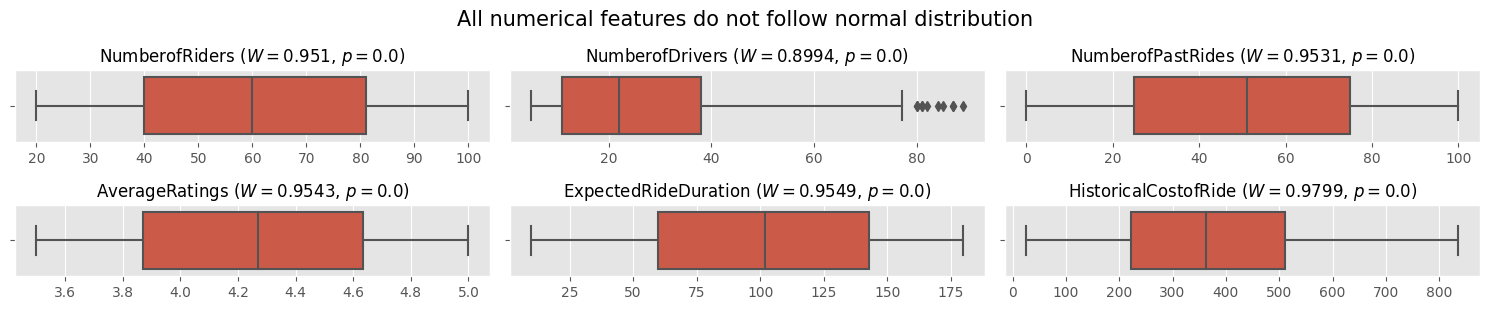

In [216]:
# compute SW test
shapiro_results = df_numeric.apply(lambda col: shapiro(col))
stats_df = pd.DataFrame({
    'column': df_numeric.columns,
    'sw_statistic': df_numeric.apply(lambda col: shapiro(col)[0]).values.round(4),
    'sw_pvalues': df_numeric.apply(lambda col: shapiro(col)[1]).values.round(4)
})

# display boxplots
plt.figure(figsize=(15, 7))
for i, col in enumerate(df_numeric.columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(x=df[col])
    # sns.stripplot(x=df[col], color='k', alpha=0.2, jitter=True)
    # locate H stat and p-val
    row = stats_df[stats_df['column'] == col]
    statistic = row['sw_statistic'].values[0]
    p_value = row['sw_pvalues'].values[0]
    plt.title(f'{col} ($W = {statistic}$, $p = {p_value}$)', size=12)
    plt.xlabel(None)
plt.suptitle('All numerical features do not follow normal distribution', size=15)
plt.tight_layout()
plt.show()

**Note**
- The visual test help me confirm the numerical test results that while the distributions are all not normal, the spreads are closer to the center. If the assumption test was only done by using visual one, it might be tempting to say that the numerical features generally have normal distribution, except for `NumberOfDrivers`.
- In addition to this confirmation, the visual test enables me to quickly investigate whether there are outliers present in the dataset. As shown, only do feature `NumbeofDrivers` contain outliers.
- The implication of the outliers is that if linear regression (linear model) or k-nearest neighbor (distance-based model) will be used among different models in the experiments, these outliers will affect the model's predictions, leading an error such as overestimation or underestimation.
- These outliers can be handled by rescaling features with a requirement of robustness towards outliers. For this reason, robust scaler can be a main option.

### **2.3 Outlier detection**
As informed previously on the normal distribution test, outliers are present only in `NumberofDrivers`. This part is a follow-up on the distribution check. This will not only confirm whether there are outliers but also quantify the number of the outliers. The number of outliers is important since higher number of outliers can significantly affect the data distribution. This check can also guide which treatment in the data preprocessing pipeline should be considered.

$$
\begin{align}
IQR &= Q3 - Q1 \\
\text{lower threshold} &= Q1 - 1.5 \times IQR \\
\text{upper threshold} &= Q3 + 1.5 \times IQR
\end{align}
$$

In [217]:
# create function to detect outliers using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df.loc[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"The number of outliers in '{column}' is {len(outliers)} or {(len(outliers)/len(df)*100):.2f}% of the total data ({len(df)} rows).")

In [218]:
# apply function to detect outliers
for i in df_numeric:
    detect_outliers(df, i)

The number of outliers in 'NumberofRiders' is 0 or 0.00% of the total data (1000 rows).
The number of outliers in 'NumberofDrivers' is 10 or 1.00% of the total data (1000 rows).
The number of outliers in 'NumberofPastRides' is 0 or 0.00% of the total data (1000 rows).
The number of outliers in 'AverageRatings' is 0 or 0.00% of the total data (1000 rows).
The number of outliers in 'ExpectedRideDuration' is 0 or 0.00% of the total data (1000 rows).
The number of outliers in 'HistoricalCostofRide' is 0 or 0.00% of the total data (1000 rows).


**Note**
- Similar to the boxplots shown in the previous section, there is only one feature containing outliers, namely `NumberofDrivers` (*N* = 10 or 1% of the total data). Since there is only a small number of outliers, they can be removed, wisorized, or rescaled. And as mentioned above, robust scaling can be an option.
- While removal or winsorization can be performed, the small sample size should be the main consideration. Removing instances containing outliers can decrease the sample size, and therefore, removal is not a good option here. Winsorization, on the other hand, can be an alternative option for robust scaling. 
- One consideration for moving forward with robust scaling is the fact that even if winsorization is done to this numerical feature, this feature will later be rescaled in order all numerical features to have the similar value ranges. For efficiency, it is possible to directly rescale this feature along with other numerical features with no outliers. The rescaling technique which can minimize the impacts of outliers is robust scaling.
- This scaling technique is more robust to outliers compared to standard scaling or min-max scaling because this technique does not use the mean, min, or max value of the feature. Instead, it uses the median and interquartile range of the feature.
$$X_{\text{scaled}} = \frac{X - X_{\text{median}}}{Q3-Q1}$$

### **2.4 Cardinality and Rarity Check**
While in Section 2.1 cardinality has been checked and there were no features with high cardinality found, the previous result has not told whether the categorical features have rare values or not. Here, my intention is to explore whether there are rare categories or not by using an arbitrary threshold at 0.01 (1%). Below 1%, the categories will be detected as rare, and hence, a treatment should be given. The treatment here is usually converting rare categories with other less frequent categories as "Others". Merging these categories will prevent the model from making biased prediction to the more frequent categories.

In [219]:
pd.DataFrame({
    'ColumnName': df.select_dtypes(include='O').columns.values.tolist(),
    'Nrow': df.select_dtypes(include='O').shape[0],
    'UniqueValue': df.select_dtypes(include='O').nunique().tolist(),
})

,ColumnName,Nrow,UniqueValue
0,LocationCategory,1000,3
1,CustomerLoyaltyStatus,1000,3
2,TimeofBooking,1000,4
3,VehicleType,1000,2


In [220]:
# check rare labels using threshold at 1%
rare_labels = {column: (df[column].value_counts() < (0.01 * len(df))).sum() 
               for column in df.select_dtypes(include=['object']).columns}

# display output in df
pd.DataFrame(rare_labels, index=[0])

,LocationCategory,CustomerLoyaltyStatus,TimeofBooking,VehicleType
0,0,0,0,0


**Note**: Operationalizing rare labels for the occurrence of categorical values under 1%, there are no rare labels found. For this reason, no treatment will be necessary.

### **2.5 Multicolinearity check**
Multicollinearity occurs when two or more features have strong correlations. When the predictors are multicorrelated, determining an independent contribution of each predictor to the target (`HistoricalCostofRide`) will become a challenge since the correlated features share explanatory power.

Commonly, multicollinearity can be detected in two ways: correlation coefficient and variance inflation factor (VIF). 
- Correlation: When the correlation coefficient between features are strong (closer to either -1 or 1), this indicates a potential multicollinearity. One main drawback of this diagnostic test is that correlation is pairwise test so complex multicollinearity involving three or more features cannot be detected. 
- Variance inflation factor: It can detect complex multicollinearity and quantify the multicollinearity. Generally, the threshold of a feature is considered high VIF is when the value is greater than 5. 

#### **2.5.1 Multicollinearity detection via correlation coefficient**
Section 2.2 informed that the distribution of numerical features are non-normal so correlation test to use here is Spearman's test. However, it is important to acknowledge the inherent limitation of this correlation test: Spearman's rho can only take numerical inputs. For this reason, categorical features should be tested using another correlation test.

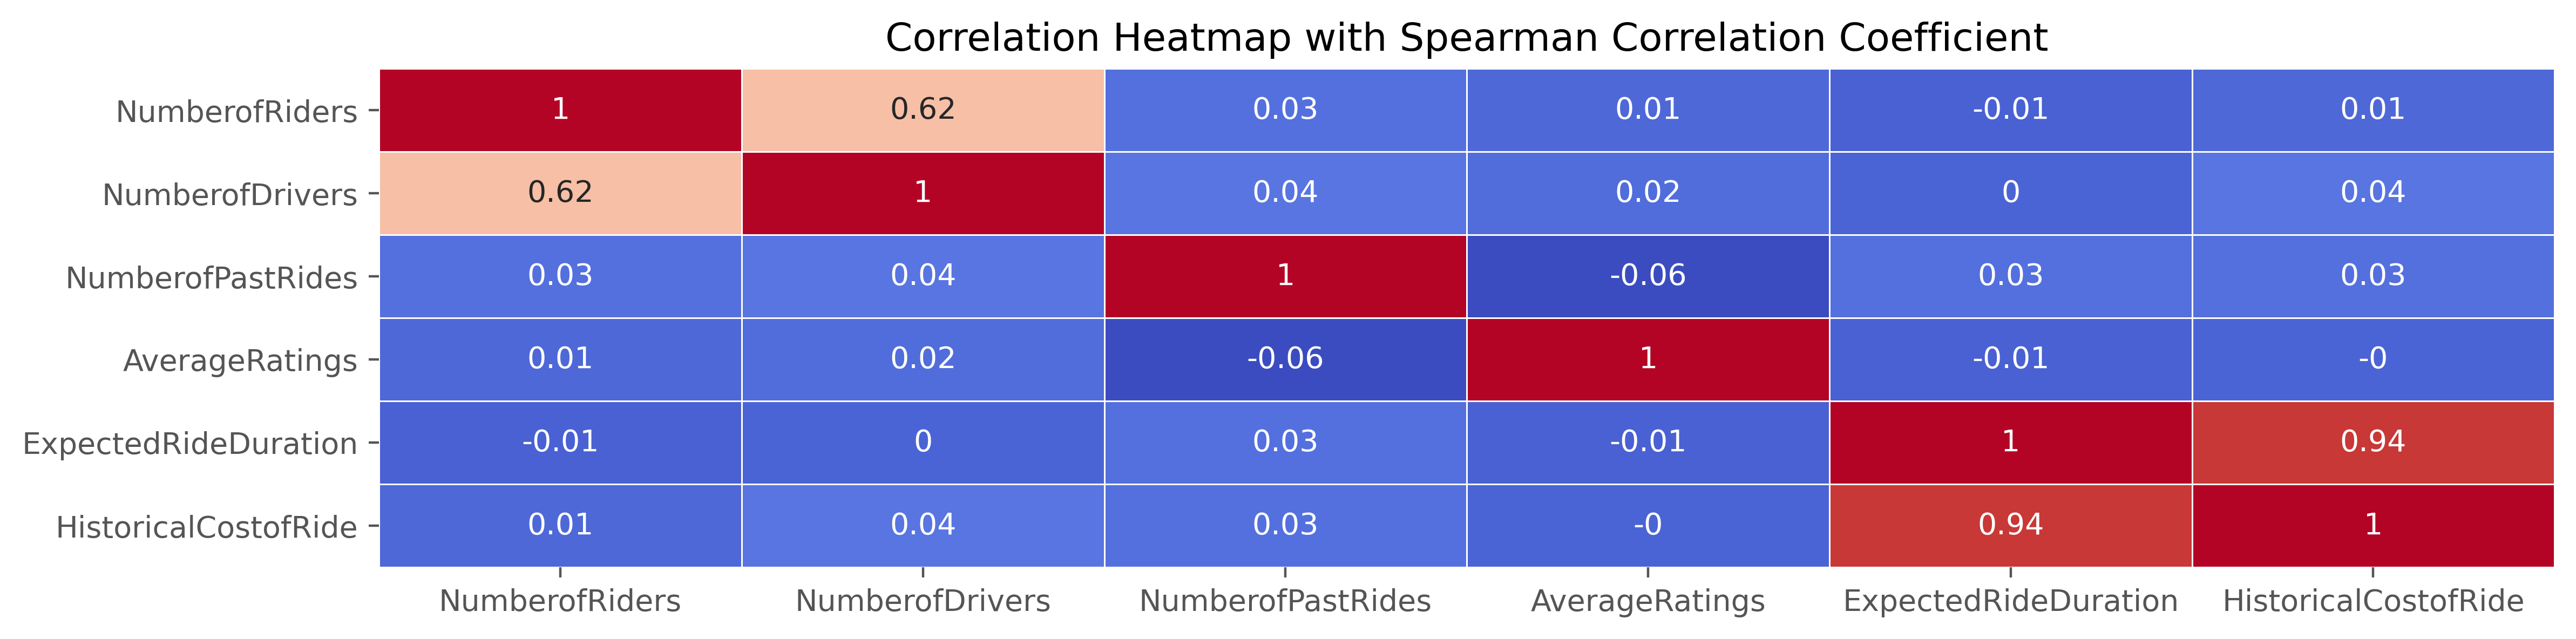

In [221]:
plt.figure(figsize=(13, 3), dpi=400)
correlation_matrix = df.select_dtypes(include='number').corr(numeric_only=True, method='spearman').round(2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, cbar=False)
plt.title('Correlation Heatmap with Spearman Correlation Coefficient', loc='center', fontsize=13)
plt.show()

**Note**
- As informed earlier, the distribution of the data is not normal so rather than using Pearson's correlation coefficient ($r$), I will use Spearman's $\rho$, a correlation test which does not assume normality of distribution.
- As can be shown, the NumberofDrivers and NumberofRiders are highly correlatred ($\rho$ = 0.62), indicating a potential multicollinearity. For this reason, one of the two variables can be excluded from the modeling phase. However, whether to exclude or include one of these two predictors from the modeling phase should be at least confirmed by the variance inflated factor (VIF) test. If the VIF value is greater than the common threshold at 5, then excluding one of the two factor can be proceed.
- While ExpectedRideDuration and HistoricalCostofRide have almost perfect correlation coefficient, their correlation value can be ignored since `HistoricalCostofRide` is the target variable. A high correlation between the predictor (`ExpectedRideDuration`) and the target indicates that the feature is potentially a strong predictor of `HistoricalCostofRide`.

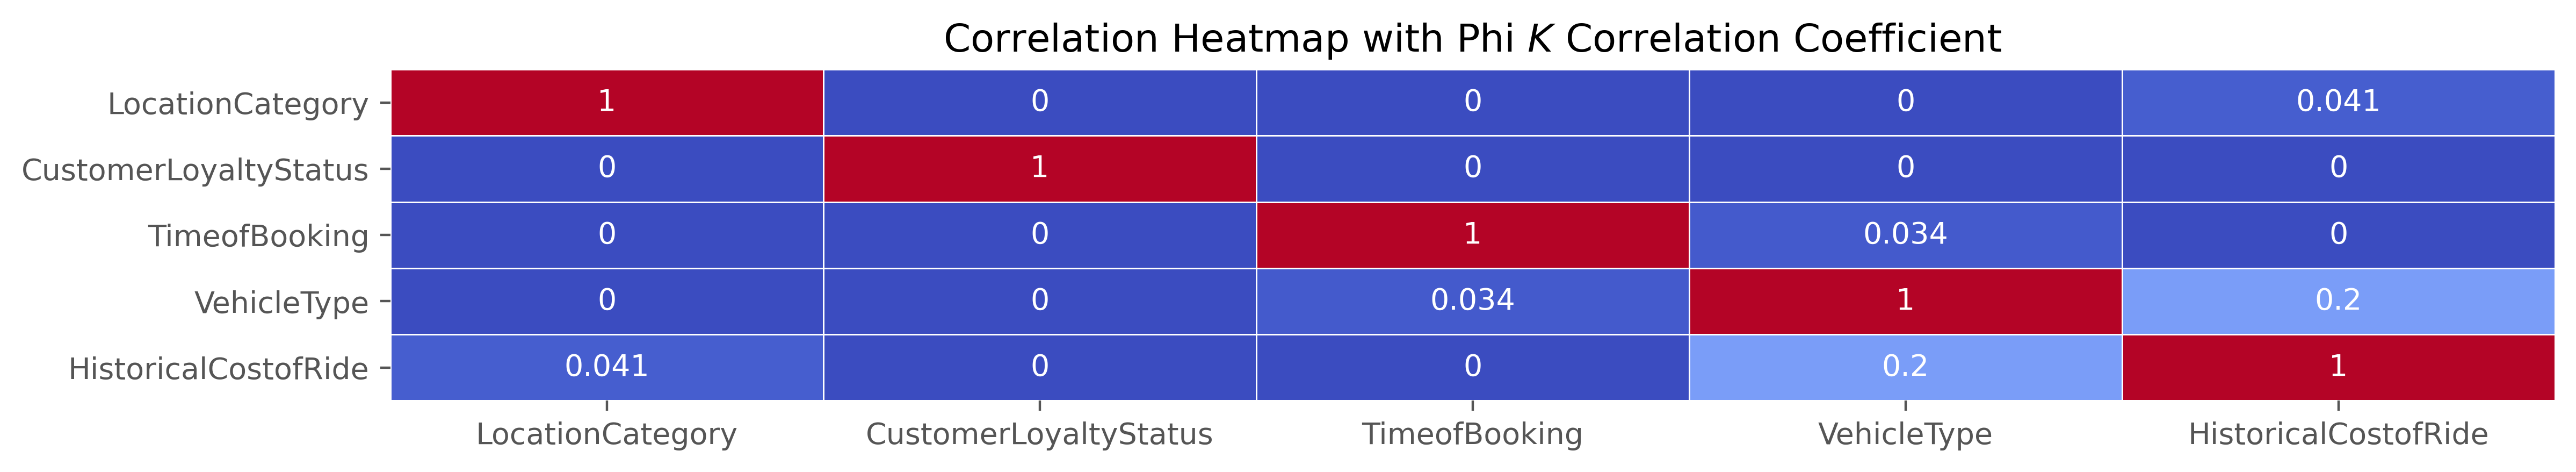

In [222]:
plt.figure(figsize=(13, 2), dpi=400)
cols = ['LocationCategory', 'CustomerLoyaltyStatus', 'TimeofBooking', 'VehicleType', 'HistoricalCostofRide']
phik_matrix = df[cols].phik_matrix(interval_cols=['HistoricalCostofRide']).round(4)
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', linewidths=0.5, cbar=False)
plt.title('Correlation Heatmap with Phi $K$ Correlation Coefficient', loc='center', fontsize=13)
plt.show()

**Note**: Based on $\Phi k$ correlation coefficients, no strong correlations can be detected, and hence, no potential multicolinearity is found in the categorical features, especially when relate them to the target variable, namely `HistoricalCostofRide`.

#### **2.5.2 Multicollinearity detection via VIF**
In its calculation, variance inflated factor (VIF) requires $R^2$ for the coefficient of determination (see below). When VIF is >5, the predictor is highly correlated with other variable(s).
$$\text{VIF} = \frac{1}{1-R^2}$$

In [223]:
# filter num vars
X = df.select_dtypes(include='number').drop(columns='HistoricalCostofRide')

# add intercept for VIF calculation
X = add_constant(X)

# compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data.round(4)

,Feature,VIF
0,const,112.9543
1,NumberofRiders,1.6487
2,NumberofDrivers,1.6535
3,NumberofPastRides,1.0070
4,AverageRatings,1.0068
5,ExpectedRideDuration,1.0018


**Note**
- As can be seen, there are no predictors with VIF greater than 5, indicating there is no multicollinarity issue in the data.
- While previously it was found that feature `NumberofRiders` is highly correlated with `NumberofDrivers` ($\rho$ = 0.62), their variance inflation factor (VIF) is 1.6, lower than 5. 
- Given the low VIF values, there is no strong reason for excluding either `NumberofDrivers` or `NumberofRiders` from the modeling phase. 

### **2.5 Summary**
This section aims to explore and clean the data before it passes to the machine learning models. It involves checking whether the parametric assumption of normality is met or not, whether there are outliers or not, whether there are rare labels, and whether there are highly correlated features. In brief, all data display non-normal distributions. There is one numerical variable contains outliers, namely `NumberofDrivers`. Moreover, rare labels were not found. For these reasons, a median-based scaling technique, namely robust scaler, will be applied on the training set to minimize the impacts of the outliers. Additionally, while `NumberofDrivers` and `NumberofRiders` are highly correlated, their high correlation does not seem a major issue when being seen using VIF. As a result, these features are retained and used for the modeling phase.

## **3 Predictive Modeling**
### **3.1 Introduction**
As the business goal is to build a regressor with minimum overestimation or underestimation of the ride cost, an ideal model is that with the smallest errors. In this section, I will conduct several experiments to investigate which model on what conditions can have the best performance. And to evaluate the performance of each regressor under different experiment setups, mean squared error (MAE), root mean squared error (RMSE), and R-squared ($R^2$) will be utilized. Just to recap their purposes which have been explained in Section 1.4,
- **Mean squared error (MAE)**: This metric evaluates prediction errors by treating small or big errors equally (no penalization for larger errors). MAE does this since it uses absolute value $|y_i-\hat{y}|$. Making the errors absolute means that direction of the errors (negative or positive) is not the concern. This metric only tells the magnitude of errors in the prediction. For example, MAE = 5 means that the prefiction if 5 units off from the actual value.
$$\text{MAE} = \frac{1}{n}\sum_{i=1}^n|y_i - \hat{y}_i|$$
- **Root mean squared error (RMSE)**: This metric also evaluates prediction errors but with penalization. By the penalization, larger errors will be penalized more. However, since RMSE involves squaring the errors, larger errors (outliers) can have significant impact on the RMSE value. In its interpretation, RMSE is similar to MAE but because it punishes larger error, RMSE value can be high if there are outliers.
$$\text{RMSE}=\sqrt{\frac{1}{n}\sum_{i=1}^1(y_i-\hat{y_1})^2}$$
- **R-squared** ($R^2$): This metric assesses a models' performance in explaining variance in the target variable. While this metric focuses more on statistical information rather than the business insight like MAE and RMSE, this metric remains useful for evaluating the overall fit of a model and how much variability in the target variable (`HistoricalCostofRide`) is explained by the predictors. For example, the R-squared of a model is 0.84 (scale 0 to 1), meaning 84% of the variability in `HistoricalCostofRide` is explained by the model.
$$
R^2=1-\frac{\sum_{i=1}^n(y_i-\hat{y}_i)^2}{\sum_{i=1}^n(y_i-\bar{y})^2}
$$
These three evaluation metrics of regressors are used but focusing on minimizing potential impact of pricing errors, RMSE will be the main priority for the evaluation. My reason is that this evaluation metric gives more penalization to larger errors, making RMSE suitable for minimizing the impacts. RMSE, therefore, addresses the risk of significant underestimation or overestimation in fare pricing prediction. 

Despite its effectiveness in penalizing larger errors (both underestimation and overestimation of prices), it is crucial to highlight the drawback of this metric: sensitivity to outliers. This trade-off between penalization and sensitivity to outliers is acceptable because outliers should be a rare case and financial impact of large errors is more important to the business.

### **3.2 ML Pipeline Preparation**

In [224]:
# split dataset
X = df.drop(columns='HistoricalCostofRide')
y = df['HistoricalCostofRide']

RANDOM_STATE = 42
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE)

print(f'The X_train consists of {X_train.shape[0]} rows and {X_train.shape[1]} columns')
print(f'The y_train consists of {y_train.shape[0]} rows')
print(f'X_test consists of {X_test.shape[0]} rows and {X_test.shape[1]} columns')
print(f'The y_test consists of {y_test.shape[0]} rows')

The X_train consists of 900 rows and 9 columns
The y_train consists of 900 rows
X_test consists of 100 rows and 9 columns
The y_test consists of 100 rows


**Note**: Since the sample size for building a regressor is small (*N* = 1,000), choosing larger size of testing set is more preferred. For example, small training data can lead to various problems such as overfitting/underfitting and reduced model complexity. 
- Overfitting can occur when a regressor memorize the small dataset instead of learning the general patterns. This leads to poor performance in unseen data.
- A small dataset can also lead to underfitting. This case particularly happens when a regressor fails to learn underlying patterns, resulting in poor performance in both training and testing data.
- When using complex algorithms, e.g., Gradient Boosting Machine or Random Forest, a small training set may not be sufficient to support them because the complex algorithms cannot fully learn the complex patterns in the data.
Due to the limited data available, the data split is done 90%:10% in which 90% data is allocated for training, and 10% is used for testing. 

In [225]:
# identify numeric and categorical features
numeric_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print('Numerical features:', numeric_features)
print('Categorical features:', categorical_features)

Numerical features: ['NumberofRiders', 'NumberofDrivers', 'NumberofPastRides', 'AverageRatings', 'ExpectedRideDuration']
Categorical features: ['LocationCategory', 'CustomerLoyaltyStatus', 'TimeofBooking', 'VehicleType']


**Note**: As previously mentioned Section 2.5, there are no predictors introducing multicolinearity to a model. An exclusion for a specific predictor is not needed. Here, I only distinguish features based on their data types (i.e., categorical and numerical) because they will require different treatments. For instance, while numerical features require rescaling to make all value ranges equal across features, values in categorical features will be transformed into numerical (encoding) so that they can be processed in the modeling process.

In [226]:
# create numerical transformer 
numerical_transformer = Pipeline(steps=[
  ('scaling', RobustScaler())
])

# create categorical transformer
categorical_transformer = Pipeline(steps=[
    ('cat', OneHotEncoder(handle_unknown='ignore'))
])

# assemble both transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaling', numerical_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

# display preprocessing pipeline
display(Pipeline(steps=[
    ('preprocessor', preprocessor)
]))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_scaling',
                                                  Pipeline(steps=[('scaling',
                                                                   RobustScaler())]),
                                                  ['NumberofRiders',
                                                   'NumberofDrivers',
                                                   'NumberofPastRides',
                                                   'AverageRatings',
                                                   'ExpectedRideDuration']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['LocationCategory',
                                                   'CustomerLoyaltyStatus',
                                                   'TimeofBooking',
                                                   'VehicleType'])]))])

**Note**: The pipeline above displays how different types of data are processed and will be fed to a machine learning algorithm. RobustScaler handles rescaling for numerical features such as `NumberofRiders`, `NumberofDrivers`, `NumberofPastRides`, `AverageRatings`, and `ExpectedRideDuration`. `OneHotEncoder`, on the other hand, encodes categories in categorical variables (`LocationCategory`, `CustomerLoyaltyStatus`, `TimeofBooking`, and `VehicleType`) into numerical values. Basically, `OneHotEncoder` converts every unique category into a binary number (1 and 0). While this encoding technique can introduce sparsity problem, this issue should not be a case in this project since no categorical variables have high cardinality.

In [227]:
# specify models for comparison
regressors = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge()),
    ('Lasso Regression', Lasso()),
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=RANDOM_STATE)),
    ('Random Forest Regressor', RandomForestRegressor(random_state=RANDOM_STATE)),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=RANDOM_STATE)),
    ('AdaBoost Regressor', AdaBoostRegressor(random_state=42)),
    ('XGBoost Regressor', XGBRegressor(eval_metric='rmse')),
    ('LightGBM Regressor', LGBMRegressor(random_state=RANDOM_STATE, verbose=-100)),
    ('CatBoost Regressor', CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)),
    ('KNN Regressor', KNeighborsRegressor()),
    ('Support Vector Regressor', SVR(kernel='rbf'))
]

# define scorer
scoring = {
    'R2': make_scorer(r2_score),
    'MAE': make_scorer(mean_absolute_error),
    'RMSE': make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False))
}

# assemble algorithm and preprocessing in a pipeline
pipelines = [(name, Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])) for name, model in regressors]

**Note**: For building a baseline model and also for a comparison purpose, I include three groups of models, namely linear-based, tree-based, and distance-based models. The inclusion of various types of models here is expected to capture patterns in the data better.
- Linear-based models: Linear Regression, Ridge Regression, and Lasso Regression
- Tree-based models: Decision Tree, Random Forest, AdaBoost, XGBoost, LightGBM, and CatBoost
- Distance-based models: K-Nearest Neighbor, Support Vector Machine (Radial Basis Function kernel)

### **3.1 Experiment 1: Baseline Models**

#### **3.1.1 Baseline Model Comparison**

In [228]:
# use K-Fold cv
kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# eval each model via model comparison
results = []
for name, pipeline in pipelines:
    scores = {}
    start_time = time.time()
    for metric_name, scorer in scoring.items():
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=scorer, n_jobs=-1)
        scores[f"{metric_name}_Mean"] = np.mean(cv_scores)
        scores[f"{metric_name}_SD"] = np.std(cv_scores)
    end_time = time.time()
    training_time = end_time - start_time
    scores['TT'] = training_time
    results.append((name, scores))

# put results in df for easier comparison
results_df = pd.DataFrame(results, columns=['Model', 'Scores'])
scores_df = results_df['Scores'].apply(pd.Series)
results_df = pd.concat([results_df[['Model']], scores_df], axis=1)
results_df = results_df.set_index('Model')

In [229]:
# display output
results_df.round(3).sort_values(by='RMSE_Mean', ascending=True)

,R2_Mean,R2_SD,MAE_Mean,MAE_SD,RMSE_Mean,RMSE_SD,TT
Model,,,,,,,
Lasso Regression,0.875,0.027,51.479,5.836,65.611,6.815,0.081
Ridge Regression,0.873,0.029,52.048,6.137,66.037,7.113,0.076
Linear Regression,0.872,0.030,52.116,6.271,66.222,7.329,0.254
Gradient Boosting Regressor,0.867,0.029,52.924,5.487,67.556,6.401,0.676
CatBoost Regressor,0.864,0.033,53.257,6.178,68.342,7.647,7.567
AdaBoost Regressor,0.862,0.027,55.577,5.658,68.924,6.750,0.375
Random Forest Regressor,0.860,0.032,53.289,5.922,69.389,7.481,1.701
LightGBM Regressor,0.856,0.034,54.092,5.781,69.969,6.691,6.647
XGBoost Regressor,0.843,0.044,55.885,6.974,73.131,8.392,0.405


**Note**
- Let me begin the explanation by pointing out the higher performance of linear-based models over tree-based and distance-based models. As can be seen the top-three models are Lasso, Ridge, and Linear Regression (linear-based). On the rank 4th to 6th, tree-based models are listed here, and followed by K-NN and SVM as the distance-based models. One important discussion here might be, "Why do linear-based models outperform other model types?" One reasonable guess is the approximately linear nature of the data. The linearity can be investigated using a residual plot which will be done later after finding the best model across all experiments.
- Besides, Lasso Regression appears to be the highest performing model in the comparison table. The mean of RMSE is 65.511 $\pm$ 6.815, indicating it has the smallest average prediction error, penalizing larger errors mode heavily than other models.
- While RMSE is the primary evaluation metric here, Lasso Regression also excels in the MAE and $R^2$.
- The linear-based model shows the smallest mean MAE (51.479), suggesting its better performance in the magnitude of errors.
- Lastly, this model also has a high $R^2$ value of 0.875. This result suggests that this model explains a significant portion of the variance in `HistoricalCostofRide`.
- These results serve as benchmarks for the machine learning models. While Lasso Regression shows excellent performance scores here, this model might not be the highest performing model on the unseen data (test data).

#### **3.1.2 Regressor Building: Top-3 Models**

In [230]:
# build pipelines
reg_linear = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
reg_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])
reg_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

# fit each model on seen data
reg_linear.fit(X_train, y_train)
reg_ridge.fit(X_train, y_train)
reg_lasso.fit(X_train, y_train)

# make predictions on unseen data
y_pred_linear = reg_linear.predict(X_test)
y_pred_ridge = reg_ridge.predict(X_test)
y_pred_lasso = reg_lasso.predict(X_test)

In [231]:
# eval metrics for linear regression
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# eval metrics for ridge regression
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Evaluate metrics for Lasso Regression
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

exp1_untuned = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'R2': [r2_linear, r2_ridge, r2_lasso],
    'RMSE': [rmse_linear, rmse_ridge, rmse_lasso],
    'MAE': [mae_linear, mae_ridge, mae_lasso]
}).round(4)

print('Performance of the top-3 untuned models:')
display(exp1_untuned.sort_values(by='RMSE', ascending=True))

Performance of the top-3 untuned models:


,Model,R2,RMSE,MAE
2,Lasso Regression,0.8487,68.4409,52.6218
1,Ridge Regression,0.8465,68.9318,53.8350
0,Linear Regression,0.8464,68.9538,53.4888


**Note**
- In testing data, Lasso Regression remains the most excellent model in predicting the fares of bike-ride services despite score reduction in MAE by 0.026 (0.875-0.849 in training set and testing set, respectively) and slight increase in errors (RMSE and MAE). However, the differences are normal because these scores are the Lasso Regression's performance in unseen data.
- To further investigate how the models, including Lasso Regression, will perform after hyperparameter tuning against unseen data to see the models' learning, I will compare the untuned and tuned versions of each model.

#### **3.1.3 Hyperparameter Tuning: Top-3 Models**

In [232]:
# define parameter grids for each model
param_grid_linear = {} # no hyperparam for linear regression

param_grid_ridge = {
    'regressor__alpha': [0.1, 1, 10, 100],
    'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr'],
}

param_grid_lasso = {
    'regressor__alpha': [0.1, 1, 10, 100],
}

# create GridSearchCV instance: linear regression
grid_search_linear = GridSearchCV(
    estimator=reg_linear,
    param_grid=param_grid_linear,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'],  
    refit = 'neg_root_mean_squared_error',
    cv=10,
    n_jobs=-1
)

# create GridSearchCV instance: ridge regression
grid_search_ridge = GridSearchCV(
    estimator=reg_ridge,
    param_grid=param_grid_ridge,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
    refit = 'neg_root_mean_squared_error',
    cv=10,
    n_jobs=-1
)

# create GridSearchCV instance: lasso regression
grid_search_lasso = GridSearchCV(
    estimator=reg_lasso,
    param_grid=param_grid_lasso,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
    refit = 'neg_root_mean_squared_error',
    cv=10,
    n_jobs=-1
)

**Note**
- Linear regression does not have hyperparameters but ridge regression and lasso regression do.
- In general, for both lasso and ridge regression, `alpha` and `solver` can be tried on. 
- The parameter `alpha` controls the regularization strength. This is a technique used to prevent overfitting.
    - In Lasso Regression, higher alpha increases the penalty for larger coefficient, which can shrink coefficients to zero.
    - In Ridge Regression, higher alpha increases the penalty for larger coefficients. Larger penalty prevents the coefficient from becoming too big and reducing model complexity.
- The last parameter, i.e., `solver`, is an algorithm for optimization.

In [233]:
# fit GridSearchCV: Linear Regression
start_time = time.time()
grid_search_linear.fit(X_train, y_train)
end_time = time.time()
time_required = end_time - start_time
print(f"Time taken for Linear Regression: {time_required:.2f} seconds")

Time taken for Linear Regression: 0.09 seconds


In [234]:
# fit GridSearchCV: Ridge Regression
start_time = time.time()
grid_search_ridge.fit(X_train, y_train)
end_time = time.time()
time_required = end_time - start_time
print(f"Time taken for Ridge Regression: {time_required:.2f} seconds")

Time taken for Ridge Regression: 0.37 seconds


In [235]:
# fit GridSearchCV: Lasso Regression
start_time = time.time()
grid_search_lasso.fit(X_train, y_train)
end_time = time.time()
time_required = end_time - start_time
print(f"Time taken for Lasso Regression: {time_required:.2f} seconds")

Time taken for Lasso Regression: 0.22 seconds


In [236]:
results_detail = {
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'Best_Param': [
        grid_search_linear.best_params_,
        grid_search_ridge.best_params_,
        grid_search_lasso.best_params_
    ],
    'R2_Mean': [
        grid_search_linear.cv_results_['mean_test_r2'][grid_search_linear.best_index_],
        grid_search_ridge.cv_results_['mean_test_r2'][grid_search_ridge.best_index_],
        grid_search_lasso.cv_results_['mean_test_r2'][grid_search_lasso.best_index_]
    ],
    'R2_SD': [
        grid_search_linear.cv_results_['std_test_r2'][grid_search_linear.best_index_],
        grid_search_ridge.cv_results_['std_test_r2'][grid_search_ridge.best_index_],
        grid_search_lasso.cv_results_['std_test_r2'][grid_search_lasso.best_index_]
    ],
    # adding negative to correct the MAE value
    'MAE_Mean': [
        -grid_search_linear.cv_results_['mean_test_neg_root_mean_squared_error'][grid_search_linear.best_index_],
        -grid_search_ridge.cv_results_['mean_test_neg_root_mean_squared_error'][grid_search_ridge.best_index_],
        -grid_search_lasso.cv_results_['mean_test_neg_root_mean_squared_error'][grid_search_lasso.best_index_]
    ],
    'MAE_SD': [
        grid_search_linear.cv_results_['std_test_neg_root_mean_squared_error'][grid_search_linear.best_index_],
        grid_search_ridge.cv_results_['std_test_neg_root_mean_squared_error'][grid_search_ridge.best_index_],
        grid_search_lasso.cv_results_['std_test_neg_root_mean_squared_error'][grid_search_lasso.best_index_]
    ],
    # adding negative to correct the RMSE value
    'RMSE_Mean': [
        -grid_search_linear.cv_results_['mean_test_neg_root_mean_squared_error'][grid_search_linear.best_index_],
        -grid_search_ridge.cv_results_['mean_test_neg_root_mean_squared_error'][grid_search_ridge.best_index_],
        -grid_search_lasso.cv_results_['mean_test_neg_root_mean_squared_error'][grid_search_lasso.best_index_]
    ],
    'RMSE_SD': [
        grid_search_linear.cv_results_['std_test_neg_root_mean_squared_error'][grid_search_linear.best_index_],
        grid_search_ridge.cv_results_['std_test_neg_root_mean_squared_error'][grid_search_ridge.best_index_],
        grid_search_lasso.cv_results_['std_test_neg_root_mean_squared_error'][grid_search_lasso.best_index_]
    ]
}

# put mean and sd of scores into df
exp1_tuned_training = pd.DataFrame(results_detail).round(4).sort_values(by='RMSE_Mean')

In [237]:
# display df
pd.options.display.max_colwidth = None
print('Model performance on training data:')
display(exp1_tuned_training)

Model performance on training data:


,Model,Best_Param,R2_Mean,R2_SD,MAE_Mean,MAE_SD,RMSE_Mean,RMSE_SD
2,Lasso Regression,{'regressor__alpha': 1},0.8743,0.0219,65.5296,5.6047,65.5296,5.6047
1,Ridge Regression,"{'regressor__alpha': 1, 'regressor__solver': 'auto'}",0.8732,0.0222,65.8198,5.5879,65.8198,5.5879
0,Linear Regression,{},0.8726,0.0223,65.9752,5.5165,65.9752,5.5165


**Note**
- The best param for both Lasso and Ridge Regression is `{'regressor__alpha': 1}`. With this alpha, both regressors apply regularization penalty helping in managing overfitting by improving the models' generalization.
- Here, the best model should have the least RMSE mean since the larger RMSE, the higher number of errors the model has. And based on the output, Lasso Regression is the best model with RMSE of 65.5296 $\pm$ 5.6047

In [244]:
# eval Lasso Regression on test set
tuned_lasso = grid_search_lasso.best_estimator_
y_pred_lasso = tuned_lasso.predict(X_test)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# eval Ridge Regression on test set
tuned_ridge = grid_search_ridge.best_estimator_
y_pred_ridge = tuned_ridge.predict(X_test)
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# eval Linear Regression on test set
tuned_linear = grid_search_linear.best_estimator_
y_pred_linear = tuned_linear.predict(X_test)
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# put results in a df
results_tuned = {
    'Model': ['Lasso Regression', 'Ridge Regression', 'Linear Regression'],
    'R2': [r2_lasso, r2_ridge, r2_linear],
    'RMSE': [rmse_lasso, rmse_ridge, rmse_linear],
    'MAE': [mae_lasso, mae_ridge, mae_linear],

}
print('Evaluation metrics on test set:')
exp1_tuned = pd.DataFrame(results_tuned).round(4)
display(exp1_tuned)

Evaluation metrics on test set:


,Model,R2,RMSE,MAE
0,Lasso Regression,0.8487,68.4409,52.6218
1,Ridge Regression,0.8465,68.9318,53.8350
2,Linear Regression,0.8464,68.9538,53.4888


#### **3.1.4 Untuned and Tuned Model Comparison**

### **3.2 Experiment 2: Polynomial Features**

#### **3.2.1 Model Building**

In [254]:
from sklearn.preprocessing import PolynomialFeatures

# Add polynomial features to the pipeline
reg_linear = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
    ('regressor', LinearRegression())
])

reg_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
    ('regressor', Ridge())
])

reg_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
    ('regressor', Lasso())
])

In [255]:
# fit each model on seen data
reg_linear.fit(X_train, y_train)
reg_ridge.fit(X_train, y_train)
reg_lasso.fit(X_train, y_train)

# make predictions on unseen data
y_pred_linear = reg_linear.predict(X_test)
y_pred_ridge = reg_ridge.predict(X_test)
y_pred_lasso = reg_lasso.predict(X_test)

In [256]:
# eval metrics for linear regression
rmse_linear = mean_squared_error(y_test, y_pred_linear, squared=False)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# eval metrics for ridge regression
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Evaluate metrics for Lasso Regression
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

exp2_untuned = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'R2': [r2_linear, r2_ridge, r2_lasso],
    'RMSE': [rmse_linear, rmse_ridge, rmse_lasso],
    'MAE': [mae_linear, mae_ridge, mae_lasso]
}).round(4)

print('Performance of the top-3 untuned models:')
display(exp2_untuned.sort_values(by='RMSE', ascending=True))

Performance of the top-3 untuned models:


,Model,R2,RMSE,MAE
2,Lasso Regression,0.8500,68.1396,52.1082
1,Ridge Regression,0.7537,87.3309,70.3220
0,Linear Regression,0.6939,97.3535,78.0441


#### **3.2.2 Hyperparameter Tuning**

In [257]:
# define parameter grids for each model
param_grid_linear = {}
param_grid_ridge = {
    'regressor__alpha': [0.1, 1, 10, 100],
    'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr'],
}

param_grid_lasso = {
    'regressor__alpha': [0.1, 1, 10, 100],
    # 'regressor__solver': ['liblinear', 'saga'], 
}

# create GridSearchCV instance: linear regression
grid_search_linear = GridSearchCV(
    estimator=reg_linear,
    param_grid=param_grid_linear,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'],  
    refit = 'neg_root_mean_squared_error',
    cv=10,
    n_jobs=-1
)

# create GridSearchCV instance: ridge regression
grid_search_ridge = GridSearchCV(
    estimator=reg_ridge,
    param_grid=param_grid_ridge,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
    refit = 'neg_root_mean_squared_error',
    cv=10,
    n_jobs=-1
)

# create GridSearchCV instance: lasso regression
grid_search_lasso = GridSearchCV(
    estimator=reg_lasso,
    param_grid=param_grid_lasso,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2'],
    refit = 'neg_root_mean_squared_error',
    cv=10,
    n_jobs=-1
)

In [258]:
# fit GridSearchCV: Linear Regression
start_time = time.time()
grid_search_linear.fit(X_train, y_train)
end_time = time.time()
time_required = end_time - start_time
print(f"Time taken for Linear Regression: {time_required:.2f} seconds")

Time taken for Linear Regression: 1.59 seconds


In [259]:
# fit GridSearchCV: Ridge Regression
start_time = time.time()
grid_search_ridge.fit(X_train, y_train)
end_time = time.time()
time_required = end_time - start_time
print(f"Time taken for Ridge Regression: {time_required:.2f} seconds")

Time taken for Ridge Regression: 7.32 seconds


In [260]:
# fit GridSearchCV: Lasso Regression
start_time = time.time()
grid_search_lasso.fit(X_train, y_train)
end_time = time.time()
time_required = end_time - start_time
print(f"Time taken for Lasso Regression: {time_required:.2f} seconds")

Time taken for Lasso Regression: 1.07 seconds


In [261]:
results_detail = {
    'Model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'Best_Param': [
        grid_search_linear.best_params_,
        grid_search_ridge.best_params_,
        grid_search_lasso.best_params_
    ],
    'R2_Mean': [
        grid_search_linear.cv_results_['mean_test_r2'][grid_search_linear.best_index_],
        grid_search_ridge.cv_results_['mean_test_r2'][grid_search_ridge.best_index_],
        grid_search_lasso.cv_results_['mean_test_r2'][grid_search_lasso.best_index_]
    ],
    'R2_SD': [
        grid_search_linear.cv_results_['std_test_r2'][grid_search_linear.best_index_],
        grid_search_ridge.cv_results_['std_test_r2'][grid_search_ridge.best_index_],
        grid_search_lasso.cv_results_['std_test_r2'][grid_search_lasso.best_index_]
    ],
    # adding negative to correct the MAE value
    'MAE_Mean': [
        -grid_search_linear.cv_results_['mean_test_neg_root_mean_squared_error'][grid_search_linear.best_index_],
        -grid_search_ridge.cv_results_['mean_test_neg_root_mean_squared_error'][grid_search_ridge.best_index_],
        -grid_search_lasso.cv_results_['mean_test_neg_root_mean_squared_error'][grid_search_lasso.best_index_]
    ],
    'MAE_SD': [
        grid_search_linear.cv_results_['std_test_neg_root_mean_squared_error'][grid_search_linear.best_index_],
        grid_search_ridge.cv_results_['std_test_neg_root_mean_squared_error'][grid_search_ridge.best_index_],
        grid_search_lasso.cv_results_['std_test_neg_root_mean_squared_error'][grid_search_lasso.best_index_]
    ],
    # adding negative to correct the RMSE value
    'RMSE_Mean': [
        -grid_search_linear.cv_results_['mean_test_neg_root_mean_squared_error'][grid_search_linear.best_index_],
        -grid_search_ridge.cv_results_['mean_test_neg_root_mean_squared_error'][grid_search_ridge.best_index_],
        -grid_search_lasso.cv_results_['mean_test_neg_root_mean_squared_error'][grid_search_lasso.best_index_]
    ],
    'RMSE_SD': [
        grid_search_linear.cv_results_['std_test_neg_root_mean_squared_error'][grid_search_linear.best_index_],
        grid_search_ridge.cv_results_['std_test_neg_root_mean_squared_error'][grid_search_ridge.best_index_],
        grid_search_lasso.cv_results_['std_test_neg_root_mean_squared_error'][grid_search_lasso.best_index_]
    ]
}

# put mean and sd of scores into df
exp2_tuned_training = pd.DataFrame(results_detail).round(4).sort_values(by='RMSE_Mean')

In [264]:
# display df
pd.options.display.max_colwidth = None
print('Model performance on training data:')
display(exp2_tuned_training)

Model performance on training data:


,Model,Best_Param,R2_Mean,R2_SD,MAE_Mean,MAE_SD,RMSE_Mean,RMSE_SD
2,Lasso Regression,{'regressor__alpha': 1},0.8722,0.0236,66.0248,5.6968,66.0248,5.6968
1,Ridge Regression,"{'regressor__alpha': 100, 'regressor__solver': 'svd'}",0.8546,0.0284,70.3460,6.1984,70.3460,6.1984
0,Linear Regression,{},0.6950,0.0781,101.3984,11.6696,101.3984,11.6696


#### **3.2.3 Untuned and Tuned Model Comparison**

### **Best Model Selection & Evaluation**

## **Reference**
- Field, A., Field, Z., & Miles, J. (2012). *Discovering statistics using R*. SAGE.

<h1 style='text-align:center; color:orange; font-weight:bold'>---END---</h1>

___